In [1]:
# 1. Read and analyze the thinking in Paper [1].
# 2. Call RDKit functions to generate molecule descriptors for the data set.
# 3. Implement machine learning models to fit and predict LogP with the selected features.

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns   
from sklearn.linear_model import RidgeCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import joblib
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn import linear_model
from keras.layers import Layer
from keras import backend as K
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.losses import binary_crossentropy



%matplotlib inline


2022-10-30 17:49:09.569704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Goal: create an algorithm f(x) that takes the smiles data as input and returns the logP as the output

# Importing synthetic dataset 
### synthetic dataset created using XLogP and does not contain experimental validation

In [61]:
df = pd.read_csv('logP_dataset.csv', names=['smiles', 'logP'])
print(df.shape)  
print(df.head())

(14610, 2)
                                        smiles  logP
0                        C[C@H]([C@@H](C)Cl)Cl   2.3
1                                    C(C=CBr)N   0.3
2                                    CCC(CO)Br   1.3
3  [13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O   2.0
4                                      CCCOCCP   0.6


##### Mol objects contain the atoms, bonds, connectivity and coordinates of a molecule. It adds important 3D information, such as the distance between atoms, that may be useful to our model. We can use Mol objects to craft features of the chemical to provide as inputs to our model

In [62]:
#Method transforms smiles strings to mol rdkit object
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

df.head()

,smiles,logP,mol
0,C[C@H]([C@@H](C)Cl)Cl,2.3,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,C(C=CBr)N,0.3,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CCC(CO)Br,1.3,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,CCCOCCP,0.6,"<img data-content=""rdkit/molecule"" src=""data:i..."


# Plotting chemical structures

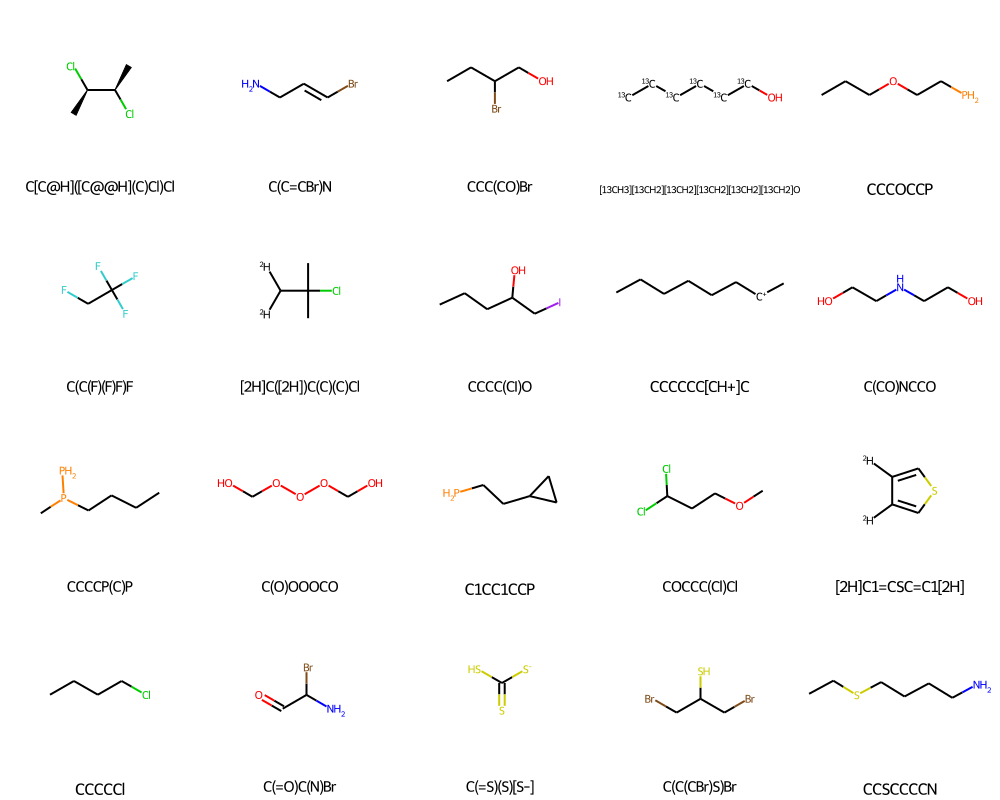

In [63]:
number_to_print = 20
mols = df['mol'][:number_to_print]

#MolsToGridImage allows to show several molecules in a grid
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:number_to_print].values))

# Viewing molecules in 3D

In [64]:
# pip install ipywidgets==7.6. 0
# pip install py3Dmol

In [65]:
import py3Dmol  
from ipywidgets import interact,fixed,IntSlider
import ipywidgets

def show3D_molecule(idx, style):
    """
    Show molecule in 3D
    """
    mblock = Chem.MolToMolBlock(df['mol'].iloc[idx])
    viewer = py3Dmol.view(width=500, height=500)
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    viewer.rotate(45, "y", animationDuration=1)
   
    viewer.zoomTo()
    
    print(f"SMILES notation: {df['smiles'].iloc[idx]}\nRotate me!");
    
    return viewer.show()
  
interact(show3D_molecule, 
         idx=ipywidgets.IntSlider(min=0,max=len(df["mol"])-1, 
                                  step=1, value=3064, 
                                  description="Molecule"),
         style=ipywidgets.Dropdown(options=['line', 'stick', 'sphere'],
                                   value='stick',
                                   description='Style:'));

interactive(children=(IntSlider(value=3064, description='Molecule', max=14609), Dropdown(description='Style:',…

# Creating features for the model
#### These features might be important for predicting logP. Such as: total number of atoms, number of Cl atoms etc

In [66]:
# AddHs function adds H atoms to a MOL (as Hs in SMILES are usualy ignored)
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))

In [67]:
# GetNumAtoms() method returns a general nubmer of all atoms in a molecule
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())

# GetNumHeavyAtoms() method returns a nubmer of all atoms in a molecule with molecular weight > 1
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

#Searching for patterns and use it for a list of most common atoms only
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C', 'O', 'N', 'Cl', 'P', 'Br', 'F'], df)

df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x)) #https://en.wikipedia.org/wiki/Polar_surface_area
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x)) # https://en.wikipedia.org/wiki/Molecular_mass
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x)) # https://en.wikipedia.org/wiki/Valence_electron
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

df.head()

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_P_atoms,num_of_Br_atoms,num_of_F_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,"<img data-content=""rdkit/molecule"" src=""data:i...",14,6,4,0,0,2,0,0,0,0.00,126.000306,38,2
1,C(C=CBr)N,0.3,"<img data-content=""rdkit/molecule"" src=""data:i...",11,5,3,0,1,0,0,1,0,26.02,134.968361,30,2
2,CCC(CO)Br,1.3,"<img data-content=""rdkit/molecule"" src=""data:i...",15,6,4,1,0,0,0,1,0,20.23,151.983677,38,2
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,"<img data-content=""rdkit/molecule"" src=""data:i...",21,7,6,1,0,0,0,0,0,20.23,108.124594,44,1
4,CCCOCCP,0.6,"<img data-content=""rdkit/molecule"" src=""data:i...",20,7,5,1,0,0,1,0,0,9.23,120.070402,44,2


In [68]:
import requests

url = 'https://github.com/samoturk/mol2vec_notebooks/raw/master/Notebooks/model_300dim.pkl'
file_to_download = requests.get(url, allow_redirects=True)

open('model_300dim.pkl', 'wb').write(file_to_download.content)

26567327

In [69]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

In [70]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec  # https://radimrehurek.com/gensim/index.html#install
w2vec_model = word2vec.Word2Vec.load('model_300dim.pkl') # Download from https://github.com/samoturk/mol2vec_notebooks/blob/master/Notebooks/model_300dim.pkl

# Mol2Vec sentences

In [71]:
#Constructing sentences
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
df['mol2vec'] = [DfVec(x) for x in sentences2vec(df['sentence'], w2vec_model, unseen='UNK')]

y = df['logP'].values
X = np.array([x.vec for x in df['mol2vec']])

# Combine features

In [72]:
X = pd.concat((pd.DataFrame(X), df.drop(["mol2vec", "sentence", "smiles", "mol", "logP"], axis=1)), axis=1)
print(X.head())

          0         1         2         3         4         5         6  \
0 -3.033099  3.074234 -5.136523  1.410768 -0.986690 -4.574900  5.233370   
1 -3.434874  1.474857 -4.590566  0.223204 -1.264612 -3.700434  5.138892   
2 -3.825828  2.155785 -6.192422 -0.167776 -0.660551 -5.452963  5.637180   
3 -4.575047  4.880448 -7.321297  1.438820 -1.936285 -6.090375  9.000039   
4 -4.621973  5.286204 -6.300099  1.157919 -1.416643 -5.956395  9.231432   

          7         8          9  ...  num_of_O_atoms  num_of_N_atoms  \
0  2.601740 -3.267953 -11.044377  ...               0               0   
1 -0.329877 -3.797274  -9.030344  ...               0               1   
2  0.801618 -4.901577 -12.064703  ...               1               0   
3 -0.387455 -6.985455 -17.531813  ...               1               0   
4 -1.259097 -6.625318 -16.902351  ...               1               0   

   num_of_Cl_atoms  num_of_P_atoms  num_of_Br_atoms  num_of_F_atoms   tpsa  \
0                2              

# Splitting synthetic dataset into Train/Validation/Test Splits


In [73]:
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=.2, random_state=816)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=.5, random_state=817)

# Pipeline for synthetic dataset
### In reference article: support vector machines, radial basis function neural networks, and multiple linear regression is 0.92, 0.90, and 0.88, respectively

In [74]:
# Ridge Regression Pipeline
ridge_pipe = Pipeline([('reg', RidgeCV())])

#Support Vector Regression (SVR) pipeline
svr_pipe = Pipeline([('reg', SVR(C=1000, epsilon=0.15, kernel='rbf'))]) #same hyperparameters used in the article

#Multiple Linear Regression pipeline
mlr_pipe = Pipeline([('reg', linear_model.LinearRegression())])

pipelines = [ridge_pipe, svr_pipe, mlr_pipe]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Ridge Regression', 1:'Support Vector Regression', 2:'Multiple Linear Regression'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)
  
# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test r2 score: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))
    
# Identify the most accurate model on test data
best_acc = 0.0
best_reg = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(X_test, y_test) > best_acc:
        best_acc = val.score(X_test, y_test)
        best_pipe = val
        best_reg = idx
print('Model with best r2 score: %s' % pipe_dict[best_reg])

# Save pipeline to file
joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
# print('Saved %s pipeline to file' % pipe_dict[best_reg])


/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support 

Ridge Regression pipeline test r2 score: 0.850
Support Vector Regression pipeline test r2 score: 0.938
Multiple Linear Regression pipeline test r2 score: 0.850


/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support 

Model with best r2 score: Support Vector Regression


['best_pipeline.pkl']

# Neural network models

### Neural network model (activation function = ReLU)

In [75]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1]), name="mol2vec")

dense1_relu = tf.keras.layers.Dense(128, activation="relu")(inputs)
drop1_relu  = tf.keras.layers.Dropout(0.3)(dense1_relu)
prediction_relu = tf.keras.layers.Dense(1, activation="linear", name="logP_value")(drop1_relu)

relu_NNM = tf.keras.models.Model(inputs=[inputs], outputs=[prediction_relu], name="logP_Model")

relu_NNM.summary()


Model: "logP_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mol2vec (InputLayer)        [(None, 113)]             0         
                                                                 
 dense_4 (Dense)             (None, 128)               14592     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 logP_value (Dense)          (None, 1)                 129       
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________


### Neural network model (activation function = sigmoid)

In [76]:
dense1_sigmoid = tf.keras.layers.Dense(128, activation="sigmoid")(inputs)
drop1_sigmoid  = tf.keras.layers.Dropout(0.3)(dense1_sigmoid)
prediction_sigmoid = tf.keras.layers.Dense(1, activation="linear", name="logP_value")(drop1_sigmoid)

sigmoid_NNM = tf.keras.models.Model(inputs=[inputs], outputs=[prediction_sigmoid], name="logP_Model")

sigmoid_NNM.summary()

Model: "logP_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mol2vec (InputLayer)        [(None, 113)]             0         
                                                                 
 dense_5 (Dense)             (None, 128)               14592     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 logP_value (Dense)          (None, 1)                 129       
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________


##### Loss and metrics
 

In [77]:
relu_NNM.compile(loss="mse",
              metrics=["mse", "mae"],
              optimizer=tf.keras.optimizers.Adam(lr=3e-4)) # Learning rate must be low

sigmoid_NNM.compile(loss="mse",
              metrics=["mse", "mae"],
              optimizer=tf.keras.optimizers.Adam(lr=3e-4))

/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Add callbacks
##### early stopping, TensorBoard, and model checkpoints. 

In [78]:
%load_ext tensorboard

stopping = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1, restore_best_weights=True)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

checkpoint_dir = "logP_model"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_loss', verbose=1, save_best_only=True)

# %tensorboard --logdir logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Fitting the neural network models (NNM) onto synthetic dataset
 

In [79]:
relu_NNM.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[stopping, tensorboard, checkpoint])


Epoch 1/1000
361/366 [============================>.] - ETA: 0s - loss: 41.4442 - mse: 41.4442 - mae: 4.5230
Epoch 1: val_loss improved from inf to 0.85904, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
366/366 [==============================] - 4s 8ms/step - loss: 41.0648 - mse: 41.0648 - mae: 4.4947 - val_loss: 0.8590 - val_mse: 0.8590 - val_mae: 0.7098
Epoch 2/1000
358/366 [============================>.] - ETA: 0s - loss: 6.0993 - mse: 6.0993 - mae: 1.5366
Epoch 2: val_loss improved from 0.85904 to 0.52981, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
366/366 [==============================] - 3s 7ms/step - loss: 6.0852 - mse: 6.0852 - mae: 1.5321 - val_loss: 0.5298 - val_mse: 0.5298 - val_mae: 0.5594
Epoch 3/1000
365/366 [============================>.] - ETA: 0s - loss: 2.4693 - mse: 2.4693 - mae: 0.9637
Epoch 3: val_loss improved from 0.52981 to 0.49357, saving model to logP_model
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: logP_model/assets
366/366 [==============================] - 7s 20ms/step - loss: 0.2609 - mse: 0.2609 - mae: 0.3855 - val_loss: 0.1835 - val_mse: 0.1835 - val_mae: 0.3184
Epoch 23/1000
365/366 [============================>.] - ETA: 0s - loss: 0.2683 - mse: 0.2683 - mae: 0.3908
Epoch 23: val_loss did not improve from 0.18355
366/366 [==============================] - 6s 15ms/step - loss: 0.2683 - mse: 0.2683 - mae: 0.3909 - val_loss: 0.1846 - val_mse: 0.1846 - val_mae: 0.3140
Epoch 24/1000
363/366 [============================>.] - ETA: 0s - loss: 0.2545 - mse: 0.2545 - mae: 0.3834
Epoch 24: val_loss improved from 0.18355 to 0.17403, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
366/366 [==============================] - 6s 17ms/step - loss: 0.2544 - mse: 0.2544 - mae: 0.3835 - val_loss: 0.1740 - val_mse: 0.1740 - val_mae: 0.3096
Epoch 25/1000
362/366 [============================>.] - ETA: 0s - loss: 0.2534 - mse: 0

362/366 [============================>.] - ETA: 0s - loss: 0.1972 - mse: 0.1972 - mae: 0.3392
Epoch 46: val_loss did not improve from 0.13272
366/366 [==============================] - 2s 4ms/step - loss: 0.1978 - mse: 0.1978 - mae: 0.3394 - val_loss: 0.1377 - val_mse: 0.1377 - val_mae: 0.2754
Epoch 47/1000
349/366 [===========================>..] - ETA: 0s - loss: 0.2007 - mse: 0.2007 - mae: 0.3407
Epoch 47: val_loss improved from 0.13272 to 0.12891, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
366/366 [==============================] - 2s 6ms/step - loss: 0.2006 - mse: 0.2006 - mae: 0.3402 - val_loss: 0.1289 - val_mse: 0.1289 - val_mae: 0.2664
Epoch 48/1000
361/366 [============================>.] - ETA: 0s - loss: 0.1964 - mse: 0.1964 - mae: 0.3364
Epoch 48: val_loss did not improve from 0.12891
366/366 [==============================] - 2s 6ms/step - loss: 0.1964 - mse: 0.1964 - mae: 0.3364 - val_loss: 0.1299 - val_mse: 0.1299 - val_mae: 0.2664
Ep

Epoch 71/1000
351/366 [===========================>..] - ETA: 0s - loss: 0.1839 - mse: 0.1839 - mae: 0.3263
Epoch 71: val_loss did not improve from 0.11838
366/366 [==============================] - 2s 4ms/step - loss: 0.1833 - mse: 0.1833 - mae: 0.3258 - val_loss: 0.1360 - val_mse: 0.1360 - val_mae: 0.2789
Epoch 72/1000
355/366 [============================>.] - ETA: 0s - loss: 0.1807 - mse: 0.1807 - mae: 0.3219
Epoch 72: val_loss did not improve from 0.11838
366/366 [==============================] - 1s 4ms/step - loss: 0.1806 - mse: 0.1806 - mae: 0.3220 - val_loss: 0.1348 - val_mse: 0.1348 - val_mae: 0.2743
Epoch 73/1000
355/366 [============================>.] - ETA: 0s - loss: 0.1860 - mse: 0.1860 - mae: 0.3280
Epoch 73: val_loss did not improve from 0.11838
366/366 [==============================] - 2s 5ms/step - loss: 0.1853 - mse: 0.1853 - mae: 0.3275 - val_loss: 0.1249 - val_mse: 0.1249 - val_mae: 0.2663
Epoch 74/1000
358/366 [============================>.] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: logP_model/assets
366/366 [==============================] - 2s 5ms/step - loss: 0.1743 - mse: 0.1743 - mae: 0.3176 - val_loss: 0.1052 - val_mse: 0.1052 - val_mae: 0.2433
Epoch 97/1000
365/366 [============================>.] - ETA: 0s - loss: 0.1720 - mse: 0.1720 - mae: 0.3153
Epoch 97: val_loss did not improve from 0.10521
366/366 [==============================] - 2s 4ms/step - loss: 0.1719 - mse: 0.1719 - mae: 0.3153 - val_loss: 0.1096 - val_mse: 0.1096 - val_mae: 0.2497
Epoch 98/1000
352/366 [===========================>..] - ETA: 0s - loss: 0.1752 - mse: 0.1752 - mae: 0.3183
Epoch 98: val_loss did not improve from 0.10521
366/366 [==============================] - 1s 4ms/step - loss: 0.1744 - mse: 0.1744 - mae: 0.3179 - val_loss: 0.1094 - val_mse: 0.1094 - val_mae: 0.2474
Epoch 99/1000
365/366 [============================>.] - ETA: 0s - loss: 0.1694 - mse: 0.1694 - mae: 0.3128
Epoch 99: val_loss did not improve from 0.10521
366/366 [===========

351/366 [===========================>..] - ETA: 0s - loss: 0.1718 - mse: 0.1718 - mae: 0.3151
Epoch 122: val_loss did not improve from 0.10220
366/366 [==============================] - 2s 5ms/step - loss: 0.1714 - mse: 0.1714 - mae: 0.3146 - val_loss: 0.1033 - val_mse: 0.1033 - val_mae: 0.2445
Epoch 123/1000
355/366 [============================>.] - ETA: 0s - loss: 0.1634 - mse: 0.1634 - mae: 0.3055
Epoch 123: val_loss improved from 0.10220 to 0.10178, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
366/366 [==============================] - 2s 5ms/step - loss: 0.1640 - mse: 0.1640 - mae: 0.3059 - val_loss: 0.1018 - val_mse: 0.1018 - val_mae: 0.2457
Epoch 124/1000
359/366 [============================>.] - ETA: 0s - loss: 0.1643 - mse: 0.1643 - mae: 0.3099
Epoch 124: val_loss did not improve from 0.10178
366/366 [==============================] - 2s 4ms/step - loss: 0.1644 - mse: 0.1644 - mae: 0.3101 - val_loss: 0.1137 - val_mse: 0.1137 - val_mae: 0.25

365/366 [============================>.] - ETA: 0s - loss: 0.1608 - mse: 0.1608 - mae: 0.3032
Epoch 147: val_loss did not improve from 0.09803
366/366 [==============================] - 2s 4ms/step - loss: 0.1609 - mse: 0.1609 - mae: 0.3033 - val_loss: 0.1085 - val_mse: 0.1085 - val_mae: 0.2497
Epoch 148/1000
362/366 [============================>.] - ETA: 0s - loss: 0.1579 - mse: 0.1579 - mae: 0.3019
Epoch 148: val_loss did not improve from 0.09803
366/366 [==============================] - 2s 4ms/step - loss: 0.1579 - mse: 0.1579 - mae: 0.3018 - val_loss: 0.1028 - val_mse: 0.1028 - val_mae: 0.2394
Epoch 149/1000
362/366 [============================>.] - ETA: 0s - loss: 0.1610 - mse: 0.1610 - mae: 0.3055
Epoch 149: val_loss did not improve from 0.09803
366/366 [==============================] - 1s 4ms/step - loss: 0.1608 - mse: 0.1608 - mae: 0.3054 - val_loss: 0.1002 - val_mse: 0.1002 - val_mae: 0.2385
Epoch 150/1000
360/366 [============================>.] - ETA: 0s - loss: 0.1597 -

INFO:tensorflow:Assets written to: logP_model/assets
366/366 [==============================] - 2s 5ms/step - loss: 0.1536 - mse: 0.1536 - mae: 0.2988 - val_loss: 0.0928 - val_mse: 0.0928 - val_mae: 0.2275
Epoch 173/1000
360/366 [============================>.] - ETA: 0s - loss: 0.1592 - mse: 0.1592 - mae: 0.3041
Epoch 173: val_loss did not improve from 0.09280
366/366 [==============================] - 1s 3ms/step - loss: 0.1589 - mse: 0.1589 - mae: 0.3039 - val_loss: 0.1040 - val_mse: 0.1040 - val_mae: 0.2433
Epoch 174/1000
358/366 [============================>.] - ETA: 0s - loss: 0.1555 - mse: 0.1555 - mae: 0.2984
Epoch 174: val_loss did not improve from 0.09280
366/366 [==============================] - 1s 3ms/step - loss: 0.1551 - mse: 0.1551 - mae: 0.2980 - val_loss: 0.0992 - val_mse: 0.0992 - val_mae: 0.2384
Epoch 175/1000
361/366 [============================>.] - ETA: 0s - loss: 0.1548 - mse: 0.1548 - mae: 0.2985
Epoch 175: val_loss did not improve from 0.09280
366/366 [=====

366/366 [==============================] - 1s 3ms/step - loss: 0.1496 - mse: 0.1496 - mae: 0.2936 - val_loss: 0.0970 - val_mse: 0.0970 - val_mae: 0.2397
Epoch 199/1000
364/366 [============================>.] - ETA: 0s - loss: 0.1504 - mse: 0.1504 - mae: 0.2953
Epoch 199: val_loss did not improve from 0.09233
366/366 [==============================] - 1s 3ms/step - loss: 0.1502 - mse: 0.1502 - mae: 0.2951 - val_loss: 0.1054 - val_mse: 0.1054 - val_mae: 0.2449
Epoch 200/1000
357/366 [============================>.] - ETA: 0s - loss: 0.1549 - mse: 0.1549 - mae: 0.2997
Epoch 200: val_loss did not improve from 0.09233
366/366 [==============================] - 1s 3ms/step - loss: 0.1545 - mse: 0.1545 - mae: 0.2992 - val_loss: 0.1078 - val_mse: 0.1078 - val_mae: 0.2475
Epoch 201/1000
350/366 [===========================>..] - ETA: 0s - loss: 0.1533 - mse: 0.1533 - mae: 0.2976
Epoch 201: val_loss did not improve from 0.09233
366/366 [==============================] - 1s 3ms/step - loss: 0.15

348/366 [===========================>..] - ETA: 0s - loss: 0.1505 - mse: 0.1505 - mae: 0.2948
Epoch 224: val_loss did not improve from 0.09017
366/366 [==============================] - 1s 3ms/step - loss: 0.1501 - mse: 0.1501 - mae: 0.2942 - val_loss: 0.1014 - val_mse: 0.1014 - val_mae: 0.2482
Epoch 225/1000
350/366 [===========================>..] - ETA: 0s - loss: 0.1516 - mse: 0.1516 - mae: 0.2952
Epoch 225: val_loss did not improve from 0.09017
366/366 [==============================] - 1s 3ms/step - loss: 0.1519 - mse: 0.1519 - mae: 0.2956 - val_loss: 0.1044 - val_mse: 0.1044 - val_mae: 0.2497
Epoch 226/1000
360/366 [============================>.] - ETA: 0s - loss: 0.1491 - mse: 0.1491 - mae: 0.2925
Epoch 226: val_loss did not improve from 0.09017
366/366 [==============================] - 1s 3ms/step - loss: 0.1492 - mse: 0.1492 - mae: 0.2927 - val_loss: 0.0989 - val_mse: 0.0989 - val_mae: 0.2443
Epoch 227/1000
364/366 [============================>.] - ETA: 0s - loss: 0.1471 -

352/366 [===========================>..] - ETA: 0s - loss: 0.1497 - mse: 0.1497 - mae: 0.2921
Epoch 250: val_loss did not improve from 0.09016
366/366 [==============================] - 1s 3ms/step - loss: 0.1498 - mse: 0.1498 - mae: 0.2922 - val_loss: 0.0938 - val_mse: 0.0938 - val_mae: 0.2272
Epoch 251/1000
359/366 [============================>.] - ETA: 0s - loss: 0.1517 - mse: 0.1517 - mae: 0.2961
Epoch 251: val_loss did not improve from 0.09016
366/366 [==============================] - 1s 3ms/step - loss: 0.1519 - mse: 0.1519 - mae: 0.2962 - val_loss: 0.0998 - val_mse: 0.0998 - val_mae: 0.2379
Epoch 252/1000
346/366 [===========================>..] - ETA: 0s - loss: 0.1482 - mse: 0.1482 - mae: 0.2932
Epoch 252: val_loss did not improve from 0.09016
366/366 [==============================] - 1s 3ms/step - loss: 0.1480 - mse: 0.1480 - mae: 0.2928 - val_loss: 0.0952 - val_mse: 0.0952 - val_mae: 0.2300
Epoch 253/1000
359/366 [============================>.] - ETA: 0s - loss: 0.1488 -

Epoch 276/1000
360/366 [============================>.] - ETA: 0s - loss: 0.1464 - mse: 0.1464 - mae: 0.2904
Epoch 276: val_loss did not improve from 0.08789
366/366 [==============================] - 1s 4ms/step - loss: 0.1458 - mse: 0.1458 - mae: 0.2899 - val_loss: 0.1081 - val_mse: 0.1081 - val_mae: 0.2458
Epoch 277/1000
346/366 [===========================>..] - ETA: 0s - loss: 0.1472 - mse: 0.1472 - mae: 0.2900
Epoch 277: val_loss did not improve from 0.08789
366/366 [==============================] - 1s 3ms/step - loss: 0.1465 - mse: 0.1465 - mae: 0.2897 - val_loss: 0.0941 - val_mse: 0.0941 - val_mae: 0.2339
Epoch 278/1000
352/366 [===========================>..] - ETA: 0s - loss: 0.1460 - mse: 0.1460 - mae: 0.2898
Epoch 278: val_loss did not improve from 0.08789
366/366 [==============================] - 1s 3ms/step - loss: 0.1463 - mse: 0.1463 - mae: 0.2898 - val_loss: 0.0900 - val_mse: 0.0900 - val_mae: 0.2255
Epoch 279/1000
344/366 [===========================>..] - ETA: 0s -

364/366 [============================>.] - ETA: 0s - loss: 0.1469 - mse: 0.1469 - mae: 0.2905
Epoch 302: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1467 - mse: 0.1467 - mae: 0.2904 - val_loss: 0.0937 - val_mse: 0.0937 - val_mae: 0.2282
Epoch 303/1000
349/366 [===========================>..] - ETA: 0s - loss: 0.1469 - mse: 0.1469 - mae: 0.2910
Epoch 303: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1471 - mse: 0.1471 - mae: 0.2912 - val_loss: 0.0907 - val_mse: 0.0907 - val_mae: 0.2288
Epoch 304/1000
363/366 [============================>.] - ETA: 0s - loss: 0.1471 - mse: 0.1471 - mae: 0.2915
Epoch 304: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1470 - mse: 0.1470 - mae: 0.2912 - val_loss: 0.1000 - val_mse: 0.1000 - val_mae: 0.2436
Epoch 305/1000
359/366 [============================>.] - ETA: 0s - loss: 0.1470 -

In [80]:
sigmoid_NNM.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[stopping, tensorboard, checkpoint])

Epoch 1/1000
354/366 [============================>.] - ETA: 0s - loss: 1.0853 - mse: 1.0853 - mae: 0.7974
Epoch 1: val_loss did not improve from 0.08586
366/366 [==============================] - 2s 4ms/step - loss: 1.0711 - mse: 1.0711 - mae: 0.7921 - val_loss: 0.5124 - val_mse: 0.5124 - val_mae: 0.5381
Epoch 2/1000
353/366 [===========================>..] - ETA: 0s - loss: 0.6325 - mse: 0.6325 - mae: 0.6161
Epoch 2: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.6278 - mse: 0.6278 - mae: 0.6141 - val_loss: 0.3827 - val_mse: 0.3827 - val_mae: 0.4643
Epoch 3/1000
366/366 [==============================] - ETA: 0s - loss: 0.4954 - mse: 0.4954 - mae: 0.5426
Epoch 3: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.4954 - mse: 0.4954 - mae: 0.5426 - val_loss: 0.3291 - val_mse: 0.3291 - val_mae: 0.4276
Epoch 4/1000
361/366 [============================>.] - ETA: 0s - loss: 0.4153 

Epoch 28/1000
350/366 [===========================>..] - ETA: 0s - loss: 0.1836 - mse: 0.1836 - mae: 0.3269
Epoch 28: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1842 - mse: 0.1842 - mae: 0.3274 - val_loss: 0.1448 - val_mse: 0.1448 - val_mae: 0.2796
Epoch 29/1000
348/366 [===========================>..] - ETA: 0s - loss: 0.1855 - mse: 0.1855 - mae: 0.3293
Epoch 29: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1849 - mse: 0.1849 - mae: 0.3291 - val_loss: 0.1326 - val_mse: 0.1326 - val_mae: 0.2679
Epoch 30/1000
363/366 [============================>.] - ETA: 0s - loss: 0.1775 - mse: 0.1775 - mae: 0.3215
Epoch 30: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1777 - mse: 0.1777 - mae: 0.3215 - val_loss: 0.1307 - val_mse: 0.1307 - val_mae: 0.2681
Epoch 31/1000
352/366 [===========================>..] - ETA: 0s - loss: 

Epoch 55/1000
362/366 [============================>.] - ETA: 0s - loss: 0.1559 - mse: 0.1559 - mae: 0.3014
Epoch 55: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1555 - mse: 0.1555 - mae: 0.3011 - val_loss: 0.1099 - val_mse: 0.1099 - val_mae: 0.2462
Epoch 56/1000
366/366 [==============================] - ETA: 0s - loss: 0.1552 - mse: 0.1552 - mae: 0.3004
Epoch 56: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1552 - mse: 0.1552 - mae: 0.3004 - val_loss: 0.1168 - val_mse: 0.1168 - val_mae: 0.2565
Epoch 57/1000
351/366 [===========================>..] - ETA: 0s - loss: 0.1517 - mse: 0.1517 - mae: 0.2969
Epoch 57: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1512 - mse: 0.1512 - mae: 0.2970 - val_loss: 0.1228 - val_mse: 0.1228 - val_mae: 0.2589
Epoch 58/1000
354/366 [============================>.] - ETA: 0s - loss: 

Epoch 82/1000
356/366 [============================>.] - ETA: 0s - loss: 0.1374 - mse: 0.1374 - mae: 0.2825
Epoch 82: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1380 - mse: 0.1380 - mae: 0.2832 - val_loss: 0.1056 - val_mse: 0.1056 - val_mae: 0.2432
Epoch 83/1000
356/366 [============================>.] - ETA: 0s - loss: 0.1406 - mse: 0.1406 - mae: 0.2859
Epoch 83: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 4ms/step - loss: 0.1397 - mse: 0.1397 - mae: 0.2851 - val_loss: 0.1043 - val_mse: 0.1043 - val_mae: 0.2393
Epoch 84/1000
366/366 [==============================] - ETA: 0s - loss: 0.1392 - mse: 0.1392 - mae: 0.2865
Epoch 84: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1392 - mse: 0.1392 - mae: 0.2865 - val_loss: 0.1156 - val_mse: 0.1156 - val_mae: 0.2494
Epoch 85/1000
360/366 [============================>.] - ETA: 0s - loss: 

366/366 [==============================] - 1s 3ms/step - loss: 0.1343 - mse: 0.1343 - mae: 0.2786 - val_loss: 0.0978 - val_mse: 0.0978 - val_mae: 0.2325
Epoch 109/1000
345/366 [===========================>..] - ETA: 0s - loss: 0.1306 - mse: 0.1306 - mae: 0.2747
Epoch 109: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1306 - mse: 0.1306 - mae: 0.2748 - val_loss: 0.1047 - val_mse: 0.1047 - val_mae: 0.2401
Epoch 110/1000
347/366 [===========================>..] - ETA: 0s - loss: 0.1316 - mse: 0.1316 - mae: 0.2765
Epoch 110: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1312 - mse: 0.1312 - mae: 0.2762 - val_loss: 0.1009 - val_mse: 0.1009 - val_mae: 0.2398
Epoch 111/1000
364/366 [============================>.] - ETA: 0s - loss: 0.1293 - mse: 0.1293 - mae: 0.2740
Epoch 111: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.12

Epoch 135/1000
357/366 [============================>.] - ETA: 0s - loss: 0.1271 - mse: 0.1271 - mae: 0.2701
Epoch 135: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1271 - mse: 0.1271 - mae: 0.2701 - val_loss: 0.0936 - val_mse: 0.0936 - val_mae: 0.2250
Epoch 136/1000
353/366 [===========================>..] - ETA: 0s - loss: 0.1258 - mse: 0.1258 - mae: 0.2697
Epoch 136: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1255 - mse: 0.1255 - mae: 0.2694 - val_loss: 0.0961 - val_mse: 0.0961 - val_mae: 0.2259
Epoch 137/1000
359/366 [============================>.] - ETA: 0s - loss: 0.1275 - mse: 0.1275 - mae: 0.2709
Epoch 137: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1274 - mse: 0.1274 - mae: 0.2708 - val_loss: 0.0957 - val_mse: 0.0957 - val_mae: 0.2287
Epoch 138/1000
365/366 [============================>.] - ETA: 0s -

343/366 [===========================>..] - ETA: 0s - loss: 0.1224 - mse: 0.1224 - mae: 0.2657
Epoch 161: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1230 - mse: 0.1230 - mae: 0.2660 - val_loss: 0.0946 - val_mse: 0.0946 - val_mae: 0.2271
Epoch 162/1000
358/366 [============================>.] - ETA: 0s - loss: 0.1202 - mse: 0.1202 - mae: 0.2643
Epoch 162: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 4ms/step - loss: 0.1204 - mse: 0.1204 - mae: 0.2646 - val_loss: 0.0940 - val_mse: 0.0940 - val_mae: 0.2298
Epoch 163/1000
352/366 [===========================>..] - ETA: 0s - loss: 0.1212 - mse: 0.1212 - mae: 0.2659
Epoch 163: val_loss did not improve from 0.08586
366/366 [==============================] - 1s 3ms/step - loss: 0.1211 - mse: 0.1211 - mae: 0.2657 - val_loss: 0.0974 - val_mse: 0.0974 - val_mae: 0.2396
Epoch 164/1000
359/366 [============================>.] - ETA: 0s - loss: 0.1180 -

# Plot some example predictions with different models


In [81]:
def plot_example(model, X_test, y_test, df, idx=0, show_3d = True):
    """
    Plot the chemical, the measured logP, and the predicted logP
    """

    prediction = np.squeeze(model.predict(np.expand_dims(X_test.iloc[idx], 0))[0])
    
    target = df[df.index==X_test.index[idx]]["logP"].values[0]
    
    if show_3d:
        show3D_molecule(idx, "stick")
    else:
        display(df[df.index==X_test.index[idx]]["mol"].values[0])
    
    smiles = df[df.index==X_test.index[idx]]["smiles"].values[0]
    
    print(f"SMILES notation: {smiles}")
    print(f"Target logP = {target:.3f}, Prediction logP = {prediction:.3f}")
    print("="*50)

In [87]:
indicies = np.random.choice(range(len(X_test)), 3) # Try a few examples

for idx in indicies:
    plot_example(relu_NNM, X_test, y_test, df, idx, show_3d=True)

1/1 [==============================] - 0s 25ms/step
SMILES notation: C1=CP=NN=P1
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: C1COCSC1
Target logP = 1.000, Prediction logP = 0.593
1/1 [==============================] - 0s 21ms/step
SMILES notation: C(C(CCl)N)F
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: CCCCCCNS
Target logP = 2.600, Prediction logP = 1.569
1/1 [==============================] - 0s 17ms/step
SMILES notation: CP(C)CI
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: CC(C)PNI
Target logP = 0.800, Prediction logP = 0.748


In [88]:
for idx in indicies:
    plot_example(ridge_pipe, X_test, y_test, df, idx, show_3d=True)

SMILES notation: C1=CP=NN=P1
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: C1COCSC1
Target logP = 1.000, Prediction logP = 0.861
SMILES notation: C(C(CCl)N)F
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: CCCCCCNS
Target logP = 2.600, Prediction logP = 1.868
SMILES notation: CP(C)CI
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: CC(C)PNI
Target logP = 0.800, Prediction logP = 0.995


In [89]:
for idx in indicies:
    plot_example(svr_pipe, X_test, y_test, df, idx, show_3d=True)

SMILES notation: C1=CP=NN=P1
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: C1COCSC1
Target logP = 1.000, Prediction logP = 0.610
SMILES notation: C(C(CCl)N)F
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: CCCCCCNS
Target logP = 2.600, Prediction logP = 1.450
SMILES notation: CP(C)CI
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: CC(C)PNI
Target logP = 0.800, Prediction logP = 0.646


In [90]:
for idx in indicies:
    plot_example(mlr_pipe, X_test, y_test, df, idx, show_3d=True)

SMILES notation: C1=CP=NN=P1
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: C1COCSC1
Target logP = 1.000, Prediction logP = 0.850
SMILES notation: C(C(CCl)N)F
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: CCCCCCNS
Target logP = 2.600, Prediction logP = 1.870
SMILES notation: CP(C)CI
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: CC(C)PNI
Target logP = 0.800, Prediction logP = 0.978


In [91]:
for idx in indicies:
    plot_example(sigmoid_NNM, X_test, y_test, df, idx, show_3d=True)

1/1 [==============================] - 0s 21ms/step
SMILES notation: C1=CP=NN=P1
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: C1COCSC1
Target logP = 1.000, Prediction logP = 0.633
1/1 [==============================] - 0s 26ms/step
SMILES notation: C(C(CCl)N)F
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: CCCCCCNS
Target logP = 2.600, Prediction logP = 1.558
1/1 [==============================] - 0s 24ms/step
SMILES notation: CP(C)CI
Rotate me!


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

SMILES notation: CC(C)PNI
Target logP = 0.800, Prediction logP = 0.901


# Plots for synthetic dataset

In [28]:
def plot_both_evaluation(relu_NNM, ridge_pipe, svr_pipe, mlr_pipe, sigmoid_NNM, X_test, y_test):
    """
    Scatter plot between target and prediction logP values for both models
    """
    
    prediction_relu_NNM = relu_NNM.predict(X_test)
    mae_relu_NNM = mean_absolute_error(y_test, prediction_relu_NNM)
    mse_relu_NNM = mean_squared_error(y_test, prediction_relu_NNM)
    r2_relu_NNM = r2_score(y_test, prediction_relu_NNM)
    
    prediction_ridge = ridge_pipe.predict(X_test)
    mae_ridge = mean_absolute_error(y_test, prediction_ridge)
    mse_ridge = mean_squared_error(y_test, prediction_ridge)
    r2_ridge = r2_score(y_test, prediction_ridge)
    
    prediction_svr = svr_pipe.predict(X_test)
    mae_svr = mean_absolute_error(y_test, prediction_svr)
    mse_svr = mean_squared_error(y_test, prediction_svr)
    r2_svr = r2_score(y_test, prediction_svr)
    
    prediction_mlr = mlr_pipe.predict(X_test)
    mae_mlr = mean_absolute_error(y_test, prediction_mlr)
    mse_mlr = mean_squared_error(y_test, prediction_mlr)
    r2_mlr = r2_score(y_test, prediction_mlr)
    
    prediction_sigmoid_NNM = sigmoid_NNM.predict(X_test)
    mae_sigmoid_NNM = mean_absolute_error(y_test, prediction_sigmoid_NNM)
    mse_sigmoid_NNM = mean_squared_error(y_test, prediction_sigmoid_NNM)
    r2_sigmoid_NNM = r2_score(y_test, prediction_sigmoid_NNM)


###Neural Network (activation function = ReLU)###
    plt.figure(figsize=(20,20))
    plt.subplot(3,2,1);
    sns.regplot(x=prediction_relu_NNM, y=y_test, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES for synthetic logP dataset', fontsize=40);
    plt.title(f'ReLU NNM: MAE = {mae_relu_NNM:.3f}, MSE = {mse_relu_NNM:.3f}, R2 = {r2_relu_NNM:.3f}', fontsize=24);
    cc = np.corrcoef(y_test, np.squeeze(prediction_relu_NNM))
    plt.text(-1.5, 2, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);

###Ridge###
    plt.subplot(3,2,2);
    sns.regplot(x=prediction_ridge, y=y_test, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES for synthetic logP dataset', fontsize=40);
    plt.title(f'Ridge MAE = {mae_ridge:.3f}, MSE = {mse_ridge:.3f}, R2 = {r2_ridge:.3f}', fontsize=24);
    cc = np.corrcoef(y_test, np.squeeze(prediction_ridge))
    plt.text(-1.5, 2, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);

###svr###
    plt.subplot(3,2,3);
    sns.regplot(x=prediction_svr, y=y_test, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES for synthetic logP dataset', fontsize=40);
    plt.title(f'SVR MAE = {mae_svr:.3f}, MSE = {mse_svr:.3f}, R2 = {r2_svr:.3f}', fontsize=24);
    cc = np.corrcoef(y_test, np.squeeze(prediction_svr))
    plt.text(-1.5, 2, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);
    
###mlr###
    plt.subplot(3,2,4);
    sns.regplot(x=prediction_mlr, y=y_test, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES for synthetic logP dataset', fontsize=40);
    plt.title(f'MLR MAE = {mae_mlr:.3f}, MSE = {mse_mlr:.3f}, R2 = {r2_mlr:.3f}', fontsize=24);
    cc = np.corrcoef(y_test, np.squeeze(prediction_mlr))
    plt.text(-1.5, 2, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);
    
###Neural Network (activation function = sigmoid)###
    plt.subplot(3,2,5);
    sns.regplot(x=prediction_sigmoid_NNM, y=y_test, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES for synthetic logP dataset', fontsize=40);
    plt.title(f'Sigmoid NNM: MAE = {mae_sigmoid_NNM:.3f}, MSE = {mse_sigmoid_NNM:.3f}, R2 = {r2_sigmoid_NNM:.3f}', fontsize=24);
    cc = np.corrcoef(y_test, np.squeeze(prediction_sigmoid_NNM))
    plt.text(-1.5, 2, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);
    plt.tight_layout(pad=5.0)

    
    

46/46 [==============================] - 0s 4ms/step


/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


46/46 [==============================] - 0s 3ms/step


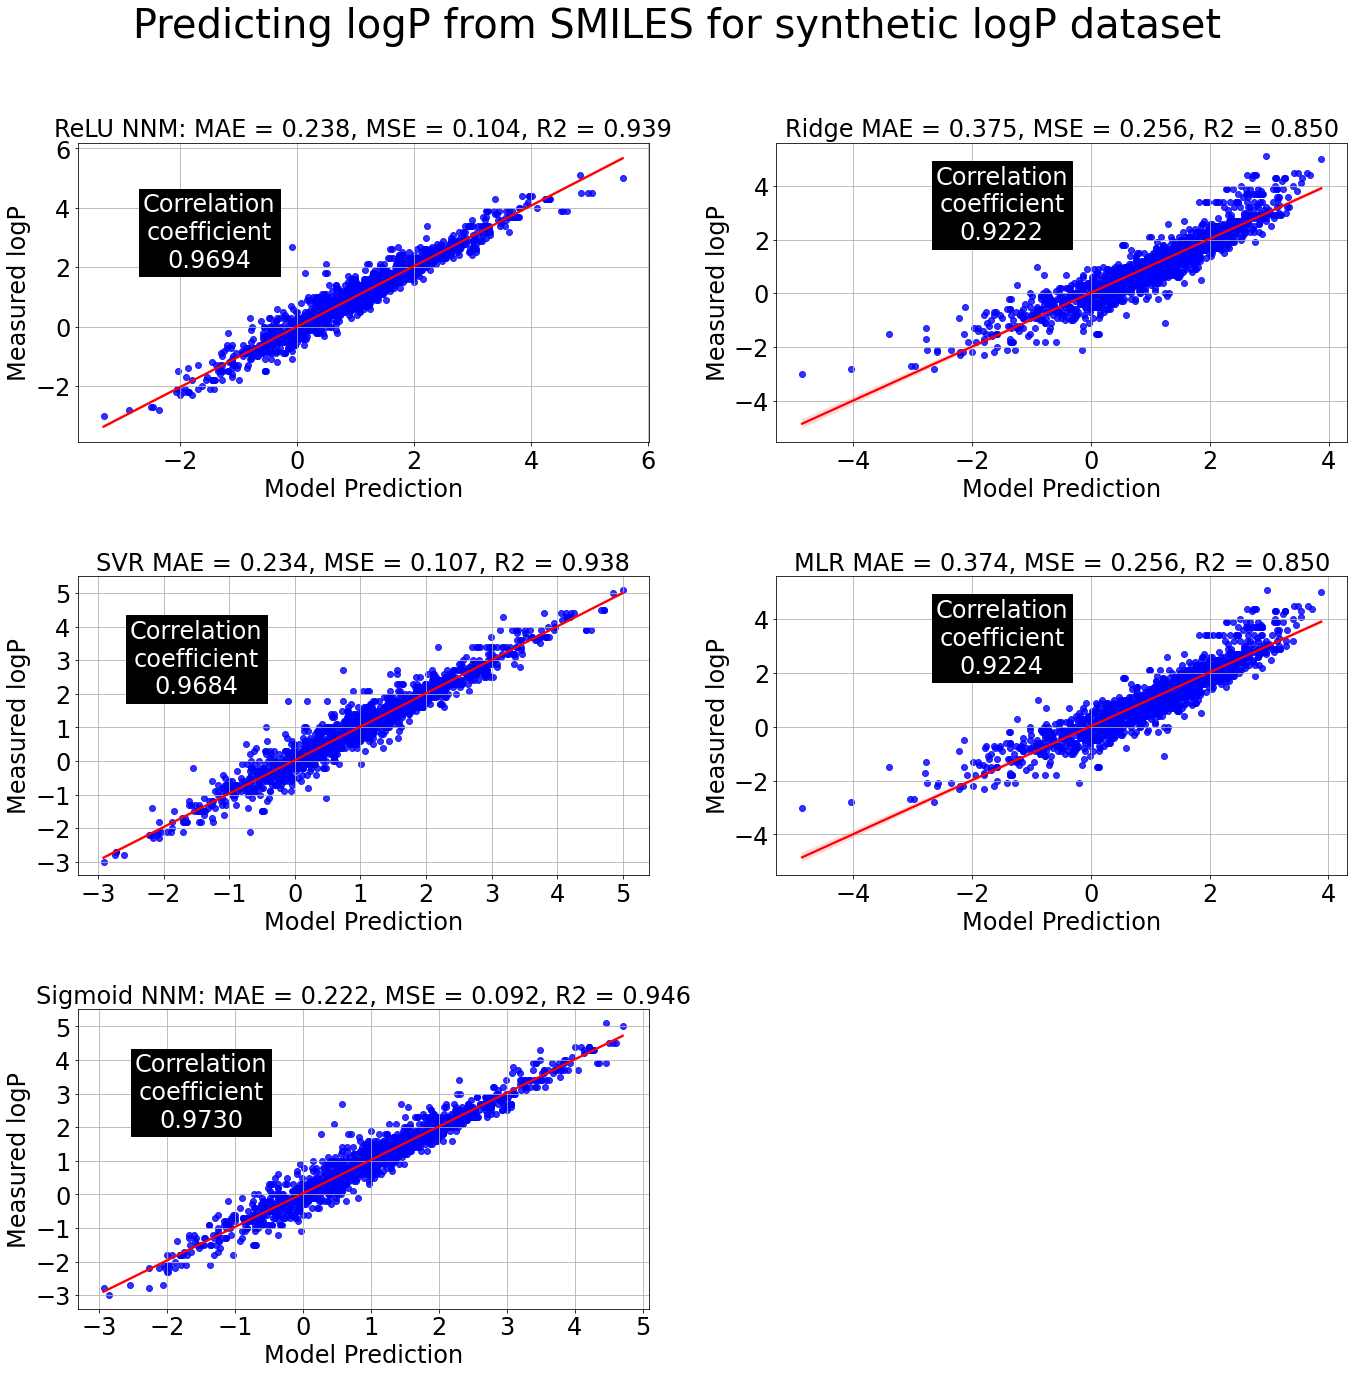

In [29]:
plot_both_evaluation(relu_NNM, ridge_pipe, svr_pipe, mlr_pipe, sigmoid_NNM, X_test, y_test)


# Import dataset with experimental logP values
### SMILES codes and experimental log P values of 759 purchased compounds (http://zinc.docking.org)

In [30]:
expt_df = pd.read_csv('logP_expt_dataset.csv', names=['smiles', 'logP'])
print(expt_df.shape)  
print(expt_df.head())

(753, 2)
                                       smiles  logP
0        Cc1cc2c(cc1C)NC(=O)C[C@H]2c3ccccc3OC  4.17
1       COc1ccc2c(c1)O[C@@](CC2=O)(C(F)(F)F)O  2.79
2  CC1(O[C@H]([C@H](O1)C(=O)N)C(=O)N)C(C)(C)C  1.60
3       CCOc1cc(cc(c1OCC)OCC)c2nnc(o2)c3ccco3  3.96
4         CN(C)c1ccc(cc1)C(=C)c2ccc(cc2)N(C)C  5.30


In [31]:
#dropping missing values
expt_df.dropna(axis=0, how='any', inplace=True)
expt_df.shape

(707, 2)

In [32]:
###confirming that there are no missing values
expt_df.isnull().sum()

smiles    0
logP      0
dtype: int64

In [33]:
expt_df['mol'] = expt_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

expt_df.head(50)

[18:08:43] SMILES Parse Error: syntax error while parsing: Cc1cc(ccc1[N+](=O)[OͲ])C(=O)NCCc2c([nH]c3c2cccc3)C
[18:08:43] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(ccc1[N+](=O)[OͲ])C(=O)NCCc2c([nH]c3c2cccc3)C' for input: 'Cc1cc(ccc1[N+](=O)[OͲ])C(=O)NCCc2c([nH]c3c2cccc3)C'
[18:08:44] SMILES Parse Error: syntax error while parsing: Cc1c(cccc1OCc2ccccc2)[N+](=O)[Oɲ]
[18:08:44] SMILES Parse Error: Failed parsing SMILES 'Cc1c(cccc1OCc2ccccc2)[N+](=O)[Oɲ]' for input: 'Cc1c(cccc1OCc2ccccc2)[N+](=O)[Oɲ]'
[18:08:44] SMILES Parse Error: syntax error while parsing: CC1(OC(=O)C(=Cc2ccc(s2)[N+](=O)[Oɲ])C(=O)O1)C
[18:08:44] SMILES Parse Error: Failed parsing SMILES 'CC1(OC(=O)C(=Cc2ccc(s2)[N+](=O)[Oɲ])C(=O)O1)C' for input: 'CC1(OC(=O)C(=Cc2ccc(s2)[N+](=O)[Oɲ])C(=O)O1)C'
[18:08:44] SMILES Parse Error: syntax error while parsing: CCOC(=O)C1=NN[C@@]2([C@@H]1C(=O)N(C2=O)c3cccc(c3)C(F)(F)F)c4cccc(c4)[N+](=O)[Oɲ]
[18:08:44] SMILES Parse Error: Failed parsing SMILES 'CCOC(=O)C1=NN[C@@]2([C@@H]1C(=O)

,smiles,logP,mol
0,Cc1cc2c(cc1C)NC(=O)C[C@H]2c3ccccc3OC,4.17,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,COc1ccc2c(c1)O[C@@](CC2=O)(C(F)(F)F)O,2.79,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CC1(O[C@H]([C@H](O1)C(=O)N)C(=O)N)C(C)(C)C,1.60,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CCOc1cc(cc(c1OCC)OCC)c2nnc(o2)c3ccco3,3.96,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,CN(C)c1ccc(cc1)C(=C)c2ccc(cc2)N(C)C,5.30,"<img data-content=""rdkit/molecule"" src=""data:i..."
5,Cc1ccc(o1)[C@H](C#CC(c2ccccc2)(c3ccccc3)O)O,3.53,"<img data-content=""rdkit/molecule"" src=""data:i..."
6,CC(C)(C)c1cc(n[nH]1)Cc2ccccc2,4.35,"<img data-content=""rdkit/molecule"" src=""data:i..."
7,C[C@H]1C[C@@H](CC(C1)(C)C)NC(=S)NCc2csc3c2cccc3,6.21,"<img data-content=""rdkit/molecule"" src=""data:i..."
8,CCNc1nc(nc(n1)Oc2ccc(nn2)OCC)NC(C)C,3.14,"<img data-content=""rdkit/molecule"" src=""data:i..."
9,c1ccc2c(c1)OCCOCCOCCO2,1.81,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [34]:
#dropping missing values
expt_df.dropna(axis=0, how='any', inplace=True)
print(expt_df.shape)

###confirming that there are no missing values
print(expt_df.isnull().sum())

(658, 3)
smiles    0
logP      0
mol       0
dtype: int64


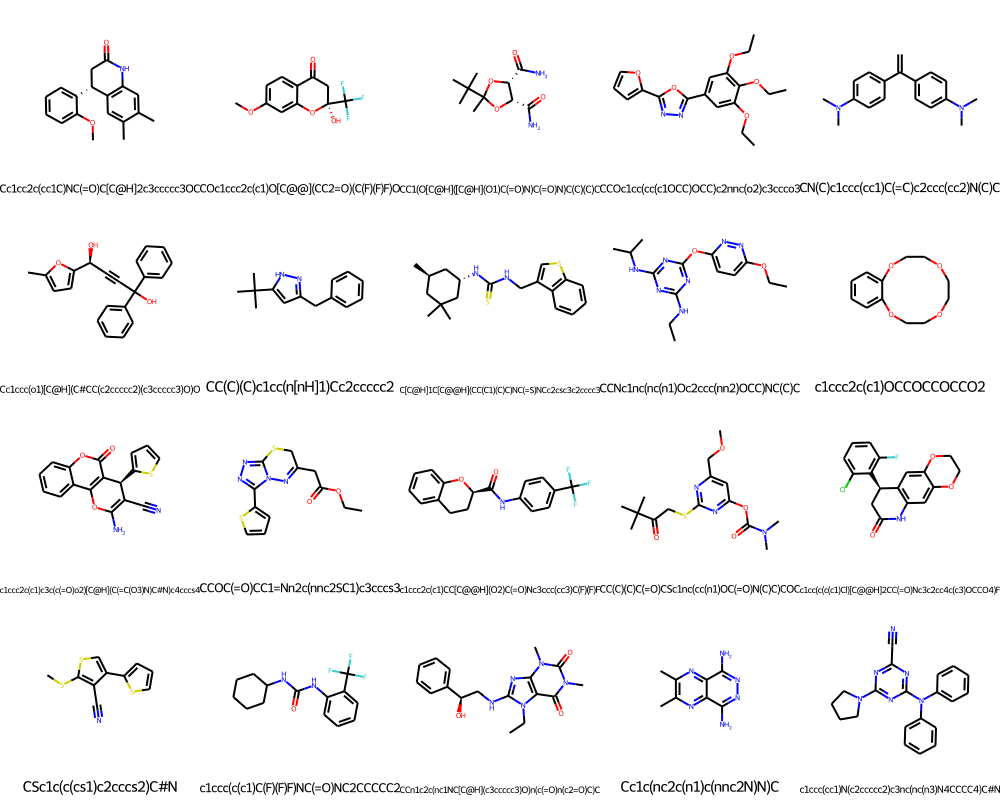

In [35]:
number_to_print = 20
mols = expt_df['mol'][:number_to_print]

#MolsToGridImage allows to show several molecules in a grid
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(expt_df['smiles'][:number_to_print].values))

# Creating features for the model

In [36]:
# AddHs function adds H atoms to a MOL (as Hs in SMILES are usualy ignored)
expt_df['mol'] = expt_df['mol'].apply(lambda x: Chem.AddHs(x))

In [37]:
# GetNumAtoms() method returns a general nubmer of all atoms in a molecule
expt_df['num_of_atoms'] = expt_df['mol'].apply(lambda x: x.GetNumAtoms())

# GetNumHeavyAtoms() method returns a nubmer of all atoms in a molecule with molecular weight > 1
expt_df['num_of_heavy_atoms'] = expt_df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

#Searching for patterns and use it for a list of most common atoms only
def number_of_atoms(atom_list, df):
    for i in atom_list:
        expt_df['num_of_{}_atoms'.format(i)] = expt_df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C', 'O', 'N', 'Cl', 'P', 'Br', 'F'], expt_df)

expt_df['tpsa'] = expt_df['mol'].apply(lambda x: Descriptors.TPSA(x)) #https://en.wikipedia.org/wiki/Polar_surface_area
expt_df['mol_w'] = expt_df['mol'].apply(lambda x: Descriptors.ExactMolWt(x)) # https://en.wikipedia.org/wiki/Molecular_mass
expt_df['num_valence_electrons'] = expt_df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x)) # https://en.wikipedia.org/wiki/Valence_electron
expt_df['num_heteroatoms'] = expt_df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

print(expt_df.shape)
expt_df.reset_index(drop=True, inplace=True)
print(expt_df.tail())

(658, 16)
                                                smiles  logP  \
653                  OCC#CC(c2ccc(F)cc2)(O)c1ccc(F)cc1  3.61   
654  CC/N=C\1/N(C(=O)/C(=C/c2cn(c3c2cccc3)CC(=O)Nc4...  5.80   
655  c1ccc2c(c1)nc(n2C[C@@H](CO)O)SCCSc3nc4ccccc4n3...  3.29   
656                              CCOC(=O)c1ccc(cc1)C#N  1.87   
657                 C=CCn(c2=O)c(SCc3ccccc3)nc1c2cccc1  5.11   

                                                   mol  num_of_atoms  \
653  <img data-content="rdkit/molecule" src="data:i...            32   
654  <img data-content="rdkit/molecule" src="data:i...            58   
655  <img data-content="rdkit/molecule" src="data:i...            58   
656  <img data-content="rdkit/molecule" src="data:i...            22   
657  <img data-content="rdkit/molecule" src="data:i...            38   

     num_of_heavy_atoms  num_of_C_atoms  num_of_O_atoms  num_of_N_atoms  \
653                  20              16               2               0   
654                  3

In [38]:
import requests

url = 'https://github.com/samoturk/mol2vec_notebooks/raw/master/Notebooks/model_300dim.pkl'
file_to_download = requests.get(url, allow_redirects=True)

open('model_300dim.pkl', 'wb').write(file_to_download.content)

26567327

In [39]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

In [40]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec  # https://radimrehurek.com/gensim/index.html#install
w2vec_model = word2vec.Word2Vec.load('model_300dim.pkl') # Download from https://github.com/samoturk/mol2vec_notebooks/blob/master/Notebooks/model_300dim.pkl

In [41]:
#Constructing sentences
expt_df['sentence'] = expt_df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
expt_df['mol2vec'] = [DfVec(x) for x in sentences2vec(expt_df['sentence'], w2vec_model, unseen='UNK')]

y = expt_df['logP'].values
X = np.array([x.vec for x in expt_df['mol2vec']])

In [42]:
X = pd.concat((pd.DataFrame(X), expt_df.drop(["mol2vec", "sentence", "smiles", "mol", "logP"], axis=1)), axis=1)
print(X.tail())

             0          1          2         3          4          5  \
653  -5.907644   7.218061 -10.314885  0.138781  -7.975831  -7.522517   
654  -9.523583  13.264157 -19.235048  2.355275 -10.269159 -20.154163   
655 -16.336416   8.531381 -19.561672  2.096289  -8.403242 -14.107118   
656  -1.605527   3.756545  -7.407247 -1.423647  -2.579208  -7.511415   
657 -10.717519   7.531511 -12.917501  1.052022  -6.413111  -9.623880   

             6         7          8          9  ...  num_of_O_atoms  \
653   6.117581 -3.444097  -7.492716 -23.604782  ...               2   
654  11.070551 -8.361683 -18.408190 -40.172409  ...               2   
655  14.221850 -3.765782 -16.532171 -44.347328  ...               4   
656   6.005766 -2.921795  -6.767901 -15.301554  ...               2   
657   9.007222 -3.321106 -10.460451 -28.206047  ...               1   

     num_of_N_atoms  num_of_Cl_atoms  num_of_P_atoms  num_of_Br_atoms  \
653               0                0               0               

In [43]:
#add a 1 behind to differentiate from synthetic logP dataset
X_train1, X_remain1, y_train1, y_remain1 = train_test_split(X, y, test_size=.2, random_state=816)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_remain1, y_remain1, test_size=.5, random_state=817)

# Fitting pipeline onto experimental dataset

In [44]:
# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train1, y_train1)
  
# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test r2 score: %.3f' % (pipe_dict[idx], val.score(X_test1, y_test1)))
    
# Identify the most accurate model on test data
best_acc = 0.0
best_reg = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(X_test1, y_test1) > best_acc:
        best_acc = val.score(X_test1, y_test1)
        best_pipe = val
        best_reg = idx
print('Model with best r2 score: %s' % pipe_dict[best_reg])

# Save pipeline to file
joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
# print('Saved %s pipeline to file' % pipe_dict[best_reg])

/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Ridge Regression pipeline test r2 score: 0.587
Support Vector Regression pipeline test r2 score: 0.582
Multiple Linear Regression pipeline test r2 score: 0.517
Model with best r2 score: Ridge Regression


/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support 

['best_pipeline.pkl']

# Neural network models for experimental dataset

### Neural network model (activation function = ReLU)

In [45]:
inputs = tf.keras.layers.Input(shape=(X_train1.shape[1]), name="mol2vec")

dense1_relu = tf.keras.layers.Dense(128, activation="relu")(inputs)
drop1_relu  = tf.keras.layers.Dropout(0.3)(dense1_relu)
prediction_relu = tf.keras.layers.Dense(1, activation="linear", name="logP_value")(drop1_relu)

relu_NNM = tf.keras.models.Model(inputs=[inputs], outputs=[prediction_relu], name="logP_Model")

relu_NNM.summary()


Model: "logP_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mol2vec (InputLayer)        [(None, 113)]             0         
                                                                 
 dense_2 (Dense)             (None, 128)               14592     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 logP_value (Dense)          (None, 1)                 129       
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________


### Neural network model (activation function = sigmoid)

In [46]:
dense1_sigmoid = tf.keras.layers.Dense(128, activation="sigmoid")(inputs)
drop1_sigmoid  = tf.keras.layers.Dropout(0.3)(dense1_sigmoid)
prediction_sigmoid = tf.keras.layers.Dense(1, activation="linear", name="logP_value")(drop1_sigmoid)

sigmoid_NNM = tf.keras.models.Model(inputs=[inputs], outputs=[prediction_sigmoid], name="logP_Model")

sigmoid_NNM.summary()

Model: "logP_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mol2vec (InputLayer)        [(None, 113)]             0         
                                                                 
 dense_3 (Dense)             (None, 128)               14592     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 logP_value (Dense)          (None, 1)                 129       
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________


### Fitting neural network models onto experimental dataset 

In [48]:
relu_NNM.compile(loss="mse",
              metrics=["mse", "mae"],
              optimizer=tf.keras.optimizers.Adam(lr=3e-4)) # Learning rate must be low

sigmoid_NNM.compile(loss="mse",
              metrics=["mse", "mae"],
              optimizer=tf.keras.optimizers.Adam(lr=3e-4))

/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [49]:
%load_ext tensorboard

stopping = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1, restore_best_weights=True)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

checkpoint_dir = "logP_model"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_loss', verbose=1, save_best_only=True)

# %tensorboard --logdir logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [50]:
relu_NNM.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, callbacks=[stopping, tensorboard, checkpoint])

Epoch 1/1000
 1/17 [>.............................] - ETA: 6s - loss: 1051.0110 - mse: 1051.0110 - mae: 27.6512
Epoch 1: val_loss improved from inf to 27.91597, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
17/17 [==============================] - 1s 36ms/step - loss: 788.1542 - mse: 788.1542 - mae: 22.0545 - val_loss: 27.9160 - val_mse: 27.9160 - val_mae: 4.0132
Epoch 2/1000
 1/17 [>.............................] - ETA: 0s - loss: 728.8765 - mse: 728.8765 - mae: 21.6152
Epoch 2: val_loss did not improve from 27.91597
17/17 [==============================] - 0s 4ms/step - loss: 595.6588 - mse: 595.6588 - mae: 18.5554 - val_loss: 28.1697 - val_mse: 28.1697 - val_mae: 4.2945
Epoch 3/1000
 1/17 [>.............................] - ETA: 0s - loss: 360.0286 - mse: 360.0286 - mae: 16.0680
Epoch 3: val_loss improved from 27.91597 to 17.21062, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
17/17 [==============================] -

Epoch 24/1000
 1/17 [>.............................] - ETA: 0s - loss: 20.2927 - mse: 20.2927 - mae: 3.4444
Epoch 24: val_loss improved from 2.28250 to 1.95144, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
17/17 [==============================] - 1s 33ms/step - loss: 21.7916 - mse: 21.7916 - mae: 3.4916 - val_loss: 1.9514 - val_mse: 1.9514 - val_mae: 1.0979
Epoch 25/1000
 1/17 [>.............................] - ETA: 0s - loss: 17.8828 - mse: 17.8828 - mae: 3.3682
Epoch 25: val_loss did not improve from 1.95144
17/17 [==============================] - 0s 4ms/step - loss: 15.2168 - mse: 15.2168 - mae: 2.9819 - val_loss: 1.9848 - val_mse: 1.9848 - val_mae: 1.0770
Epoch 26/1000
 1/17 [>.............................] - ETA: 0s - loss: 17.7911 - mse: 17.7911 - mae: 3.1717
Epoch 26: val_loss did not improve from 1.95144
17/17 [==============================] - 0s 4ms/step - loss: 12.9017 - mse: 12.9017 - mae: 2.7542 - val_loss: 2.1408 - val_mse: 2.1408 - val

17/17 [==============================] - 0s 5ms/step - loss: 3.8432 - mse: 3.8432 - mae: 1.3639 - val_loss: 1.0443 - val_mse: 1.0443 - val_mae: 0.7815
Epoch 48/1000
 1/17 [>.............................] - ETA: 0s - loss: 3.9039 - mse: 3.9039 - mae: 1.2378
Epoch 48: val_loss improved from 0.96155 to 0.93824, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
17/17 [==============================] - 1s 36ms/step - loss: 3.3366 - mse: 3.3366 - mae: 1.3221 - val_loss: 0.9382 - val_mse: 0.9382 - val_mae: 0.7531
Epoch 49/1000
10/17 [================>.............] - ETA: 0s - loss: 4.4519 - mse: 4.4519 - mae: 1.4900
Epoch 49: val_loss did not improve from 0.93824
17/17 [==============================] - 0s 10ms/step - loss: 3.6509 - mse: 3.6509 - mae: 1.3724 - val_loss: 1.0197 - val_mse: 1.0197 - val_mae: 0.7853
Epoch 50/1000
 1/17 [>.............................] - ETA: 0s - loss: 1.8595 - mse: 1.8595 - mae: 1.0412
Epoch 50: val_loss did not improve from 0.9382

 1/17 [>.............................] - ETA: 0s - loss: 1.9049 - mse: 1.9049 - mae: 1.0716
Epoch 71: val_loss did not improve from 0.81074
17/17 [==============================] - 0s 8ms/step - loss: 2.0937 - mse: 2.0937 - mae: 1.0945 - val_loss: 0.8232 - val_mse: 0.8232 - val_mae: 0.7127
Epoch 72/1000
14/17 [=======================>......] - ETA: 0s - loss: 2.0814 - mse: 2.0814 - mae: 1.0927
Epoch 72: val_loss did not improve from 0.81074
17/17 [==============================] - 0s 7ms/step - loss: 2.0772 - mse: 2.0772 - mae: 1.0901 - val_loss: 0.8282 - val_mse: 0.8282 - val_mae: 0.7245
Epoch 73/1000
 1/17 [>.............................] - ETA: 0s - loss: 2.7967 - mse: 2.7967 - mae: 1.3368
Epoch 73: val_loss improved from 0.81074 to 0.80360, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
17/17 [==============================] - 1s 37ms/step - loss: 2.0161 - mse: 2.0161 - mae: 1.1043 - val_loss: 0.8036 - val_mse: 0.8036 - val_mae: 0.7135
Epoch 74/1000

17/17 [==============================] - ETA: 0s - loss: 1.7147 - mse: 1.7147 - mae: 0.9751
Epoch 94: val_loss improved from 0.63353 to 0.63173, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
17/17 [==============================] - 1s 51ms/step - loss: 1.7147 - mse: 1.7147 - mae: 0.9751 - val_loss: 0.6317 - val_mse: 0.6317 - val_mae: 0.6470
Epoch 95/1000
 1/17 [>.............................] - ETA: 0s - loss: 2.0565 - mse: 2.0565 - mae: 1.0799
Epoch 95: val_loss did not improve from 0.63173
17/17 [==============================] - 0s 6ms/step - loss: 1.8162 - mse: 1.8162 - mae: 1.0295 - val_loss: 0.6367 - val_mse: 0.6367 - val_mae: 0.6428
Epoch 96/1000
 1/17 [>.............................] - ETA: 0s - loss: 1.4511 - mse: 1.4511 - mae: 0.8581
Epoch 96: val_loss did not improve from 0.63173
17/17 [==============================] - 0s 6ms/step - loss: 1.6355 - mse: 1.6355 - mae: 0.9520 - val_loss: 0.6576 - val_mse: 0.6576 - val_mae: 0.6531
Epoch 97/1000

 1/17 [>.............................] - ETA: 0s - loss: 1.0872 - mse: 1.0872 - mae: 0.7623
Epoch 118: val_loss did not improve from 0.57470
17/17 [==============================] - 0s 6ms/step - loss: 1.4974 - mse: 1.4974 - mae: 0.9313 - val_loss: 0.5797 - val_mse: 0.5797 - val_mae: 0.5994
Epoch 119/1000
 9/17 [==============>...............] - ETA: 0s - loss: 1.4047 - mse: 1.4047 - mae: 0.9103
Epoch 119: val_loss did not improve from 0.57470
17/17 [==============================] - 0s 9ms/step - loss: 1.3159 - mse: 1.3159 - mae: 0.8981 - val_loss: 0.5900 - val_mse: 0.5900 - val_mae: 0.6084
Epoch 120/1000
 1/17 [>.............................] - ETA: 0s - loss: 0.7441 - mse: 0.7441 - mae: 0.6802
Epoch 120: val_loss improved from 0.57470 to 0.57062, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
17/17 [==============================] - 1s 71ms/step - loss: 1.3910 - mse: 1.3910 - mae: 0.9033 - val_loss: 0.5706 - val_mse: 0.5706 - val_mae: 0.6027
Epoch 12

Epoch 143/1000
 1/17 [>.............................] - ETA: 0s - loss: 1.6766 - mse: 1.6766 - mae: 0.8576
Epoch 143: val_loss improved from 0.53270 to 0.52115, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
17/17 [==============================] - 1s 38ms/step - loss: 1.2766 - mse: 1.2766 - mae: 0.8840 - val_loss: 0.5211 - val_mse: 0.5211 - val_mae: 0.5718
Epoch 144/1000
 1/17 [>.............................] - ETA: 0s - loss: 0.9375 - mse: 0.9375 - mae: 0.8011
Epoch 144: val_loss improved from 0.52115 to 0.51371, saving model to logP_model
INFO:tensorflow:Assets written to: logP_model/assets
17/17 [==============================] - 1s 43ms/step - loss: 1.2457 - mse: 1.2457 - mae: 0.8754 - val_loss: 0.5137 - val_mse: 0.5137 - val_mae: 0.5643
Epoch 145/1000
 1/17 [>.............................] - ETA: 0s - loss: 2.8977 - mse: 2.8977 - mae: 1.1911
Epoch 145: val_loss did not improve from 0.51371
17/17 [==============================] - 0s 4ms/step - los

 1/17 [>.............................] - ETA: 0s - loss: 2.0514 - mse: 2.0514 - mae: 1.0977
Epoch 168: val_loss did not improve from 0.49875
17/17 [==============================] - 0s 6ms/step - loss: 1.3930 - mse: 1.3930 - mae: 0.9205 - val_loss: 0.5107 - val_mse: 0.5107 - val_mae: 0.5681
Epoch 169/1000
 1/17 [>.............................] - ETA: 0s - loss: 0.9828 - mse: 0.9828 - mae: 0.8086
Epoch 169: val_loss did not improve from 0.49875
17/17 [==============================] - 0s 5ms/step - loss: 1.1329 - mse: 1.1329 - mae: 0.8466 - val_loss: 0.5205 - val_mse: 0.5205 - val_mae: 0.5810
Epoch 170/1000
 1/17 [>.............................] - ETA: 0s - loss: 0.8559 - mse: 0.8559 - mae: 0.7255
Epoch 170: val_loss did not improve from 0.49875
17/17 [==============================] - 0s 7ms/step - loss: 1.2998 - mse: 1.2998 - mae: 0.8853 - val_loss: 0.5169 - val_mse: 0.5169 - val_mae: 0.5647
Epoch 171/1000
 1/17 [>.............................] - ETA: 0s - loss: 1.2164 - mse: 1.2164 -

15/17 [=========================>....] - ETA: 0s - loss: 1.1661 - mse: 1.1661 - mae: 0.8376
Epoch 194: val_loss did not improve from 0.47707
17/17 [==============================] - 0s 19ms/step - loss: 1.1451 - mse: 1.1451 - mae: 0.8330 - val_loss: 0.5543 - val_mse: 0.5543 - val_mae: 0.5867
Epoch 195/1000
12/17 [====================>.........] - ETA: 0s - loss: 1.1284 - mse: 1.1284 - mae: 0.8260
Epoch 195: val_loss did not improve from 0.47707
17/17 [==============================] - 0s 12ms/step - loss: 1.2269 - mse: 1.2269 - mae: 0.8482 - val_loss: 0.5237 - val_mse: 0.5237 - val_mae: 0.5708
Epoch 196/1000
10/17 [================>.............] - ETA: 0s - loss: 1.1662 - mse: 1.1662 - mae: 0.8095
Epoch 196: val_loss did not improve from 0.47707
17/17 [==============================] - 0s 11ms/step - loss: 1.1718 - mse: 1.1718 - mae: 0.8179 - val_loss: 0.5252 - val_mse: 0.5252 - val_mae: 0.5691
Epoch 197/1000
13/17 [=====================>........] - ETA: 0s - loss: 1.3754 - mse: 1.375

In [51]:
sigmoid_NNM.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, callbacks=[stopping, tensorboard, checkpoint])

Epoch 1/1000
 1/17 [>.............................] - ETA: 15s - loss: 17.5524 - mse: 17.5524 - mae: 4.0260
Epoch 1: val_loss did not improve from 0.47707
17/17 [==============================] - 1s 20ms/step - loss: 13.6683 - mse: 13.6683 - mae: 3.4032 - val_loss: 8.1668 - val_mse: 8.1668 - val_mae: 2.6735
Epoch 2/1000
 7/17 [===========>..................] - ETA: 0s - loss: 7.2892 - mse: 7.2892 - mae: 2.3932
Epoch 2: val_loss did not improve from 0.47707
17/17 [==============================] - 0s 14ms/step - loss: 5.9998 - mse: 5.9998 - mae: 2.1290 - val_loss: 2.5916 - val_mse: 2.5916 - val_mae: 1.3006
Epoch 3/1000
15/17 [=========================>....] - ETA: 0s - loss: 2.9428 - mse: 2.9428 - mae: 1.4165
Epoch 3: val_loss did not improve from 0.47707
17/17 [==============================] - 0s 10ms/step - loss: 2.8965 - mse: 2.8965 - mae: 1.4043 - val_loss: 1.6052 - val_mse: 1.6052 - val_mae: 1.0064
Epoch 4/1000
13/17 [=====================>........] - ETA: 0s - loss: 2.2285 - mse:

Epoch 28/1000
 1/17 [>.............................] - ETA: 0s - loss: 2.0795 - mse: 2.0795 - mae: 1.1340
Epoch 28: val_loss did not improve from 0.47707
17/17 [==============================] - 0s 6ms/step - loss: 1.5057 - mse: 1.5057 - mae: 0.9821 - val_loss: 0.9047 - val_mse: 0.9047 - val_mae: 0.8056
Epoch 29/1000
 1/17 [>.............................] - ETA: 0s - loss: 1.5094 - mse: 1.5094 - mae: 0.8660
Epoch 29: val_loss did not improve from 0.47707
17/17 [==============================] - 0s 7ms/step - loss: 1.5253 - mse: 1.5253 - mae: 0.9600 - val_loss: 0.9150 - val_mse: 0.9150 - val_mae: 0.8100
Epoch 30/1000
13/17 [=====================>........] - ETA: 0s - loss: 1.5083 - mse: 1.5083 - mae: 0.9734
Epoch 30: val_loss did not improve from 0.47707
17/17 [==============================] - 0s 9ms/step - loss: 1.4579 - mse: 1.4579 - mae: 0.9620 - val_loss: 0.9261 - val_mse: 0.9261 - val_mae: 0.8100
Epoch 31/1000
14/17 [=======================>......] - ETA: 0s - loss: 1.4258 - mse: 

# Plots for experimental logP dataset

In [58]:
def plot_both_evaluation(relu_NNM, ridge_pipe, svr_pipe, mlr_pipe, sigmoid_NNM, X_test1, y_test1):
    """
    Scatter plot between target and prediction logP values for both models
    """
    
    prediction_relu_NNM = relu_NNM.predict(X_test1)
    mae_relu_NNM = mean_absolute_error(y_test1, prediction_relu_NNM)
    mse_relu_NNM = mean_squared_error(y_test1, prediction_relu_NNM)
    r2_relu_NNM = r2_score(y_test1, prediction_relu_NNM)
    
    prediction_ridge = ridge_pipe.predict(X_test1)
    mae_ridge = mean_absolute_error(y_test1, prediction_ridge)
    mse_ridge = mean_squared_error(y_test1, prediction_ridge)
    r2_ridge = r2_score(y_test1, prediction_ridge)
    
    prediction_svr = svr_pipe.predict(X_test1)
    mae_svr = mean_absolute_error(y_test1, prediction_svr)
    mse_svr = mean_squared_error(y_test1, prediction_svr)
    r2_svr = r2_score(y_test1, prediction_svr)
    
    prediction_mlr = mlr_pipe.predict(X_test1)
    mae_mlr = mean_absolute_error(y_test1, prediction_mlr)
    mse_mlr = mean_squared_error(y_test1, prediction_mlr)
    r2_mlr = r2_score(y_test1, prediction_mlr)
    
    prediction_sigmoid_NNM = sigmoid_NNM.predict(X_test1)
    mae_sigmoid_NNM = mean_absolute_error(y_test1, prediction_sigmoid_NNM)
    mse_sigmoid_NNM = mean_squared_error(y_test1, prediction_sigmoid_NNM)
    r2_sigmoid_NNM = r2_score(y_test1, prediction_sigmoid_NNM)


###Neural Network (activation function = ReLU)###
    plt.figure(figsize=(20,20))
    plt.subplot(3,2,1);
    sns.regplot(x=prediction_relu_NNM, y=y_test1, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES for experimental logP dataset', fontsize=40);
    plt.title(f'ReLU NNM: MAE = {mae_relu_NNM:.3f}, MSE = {mse_relu_NNM:.3f}, R2 = {r2_relu_NNM:.3f}', fontsize=24);
    cc = np.corrcoef(y_test1, np.squeeze(prediction_relu_NNM))
    plt.text(2, 4.5, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);

###Ridge###
    plt.subplot(3,2,2);
    sns.regplot(x=prediction_ridge, y=y_test1, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES for experimental logP dataset', fontsize=40);
    plt.title(f'Ridge MAE = {mae_ridge:.3f}, MSE = {mse_ridge:.3f}, R2 = {r2_ridge:.3f}', fontsize=24);
    cc = np.corrcoef(y_test1, np.squeeze(prediction_ridge))
    plt.text(2, 4.5, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);

###svr###
    plt.subplot(3,2,3);
    sns.regplot(x=prediction_svr, y=y_test1, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES for experimental logP dataset', fontsize=40);
    plt.title(f'SVR MAE = {mae_svr:.3f}, MSE = {mse_svr:.3f}, R2 = {r2_svr:.3f}', fontsize=24);
    cc = np.corrcoef(y_test1, np.squeeze(prediction_svr))
    plt.text(2, 4.5, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);
    
###mlr###
    plt.subplot(3,2,4);
    sns.regplot(x=prediction_mlr, y=y_test1, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES for experimental logP dataset', fontsize=40);
    plt.title(f'MLR MAE = {mae_mlr:.3f}, MSE = {mse_mlr:.3f}, R2 = {r2_mlr:.3f}', fontsize=24);
    cc = np.corrcoef(y_test1, np.squeeze(prediction_mlr))
    plt.text(2, 4.5, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);
    
###Neural Network (activation function = sigmoid)###
    plt.subplot(3,2,5);
    sns.regplot(x=prediction_sigmoid_NNM, y=y_test1, scatter_kws={"color": "blue"}, line_kws={"color": "red"});
    plt.xlabel('Model Prediction', fontsize=24);
    plt.ylabel('Measured logP', fontsize=24);
    plt.xticks(fontsize=24);
    plt.yticks(fontsize=24);
    plt.suptitle('Predicting logP from SMILES for experimental logP dataset', fontsize=40);
    plt.title(f'Sigmoid NNM: MAE = {mae_sigmoid_NNM:.3f}, MSE = {mse_sigmoid_NNM:.3f}, R2 = {r2_sigmoid_NNM:.3f}', fontsize=24);
    cc = np.corrcoef(y_test1, np.squeeze(prediction_sigmoid_NNM))
    plt.text(3, 4.5, f"Correlation\ncoefficient\n{cc[0][1]:.4f}", fontsize=24, 
             horizontalalignment="center", backgroundcolor="black", color="white")
    plt.grid(True);
    plt.tight_layout(pad=5.0)


3/3 [==============================] - 0s 3ms/step


/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/lynettekhoo/opt/anaconda3/envs/lynette_py38_1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


3/3 [==============================] - 0s 3ms/step


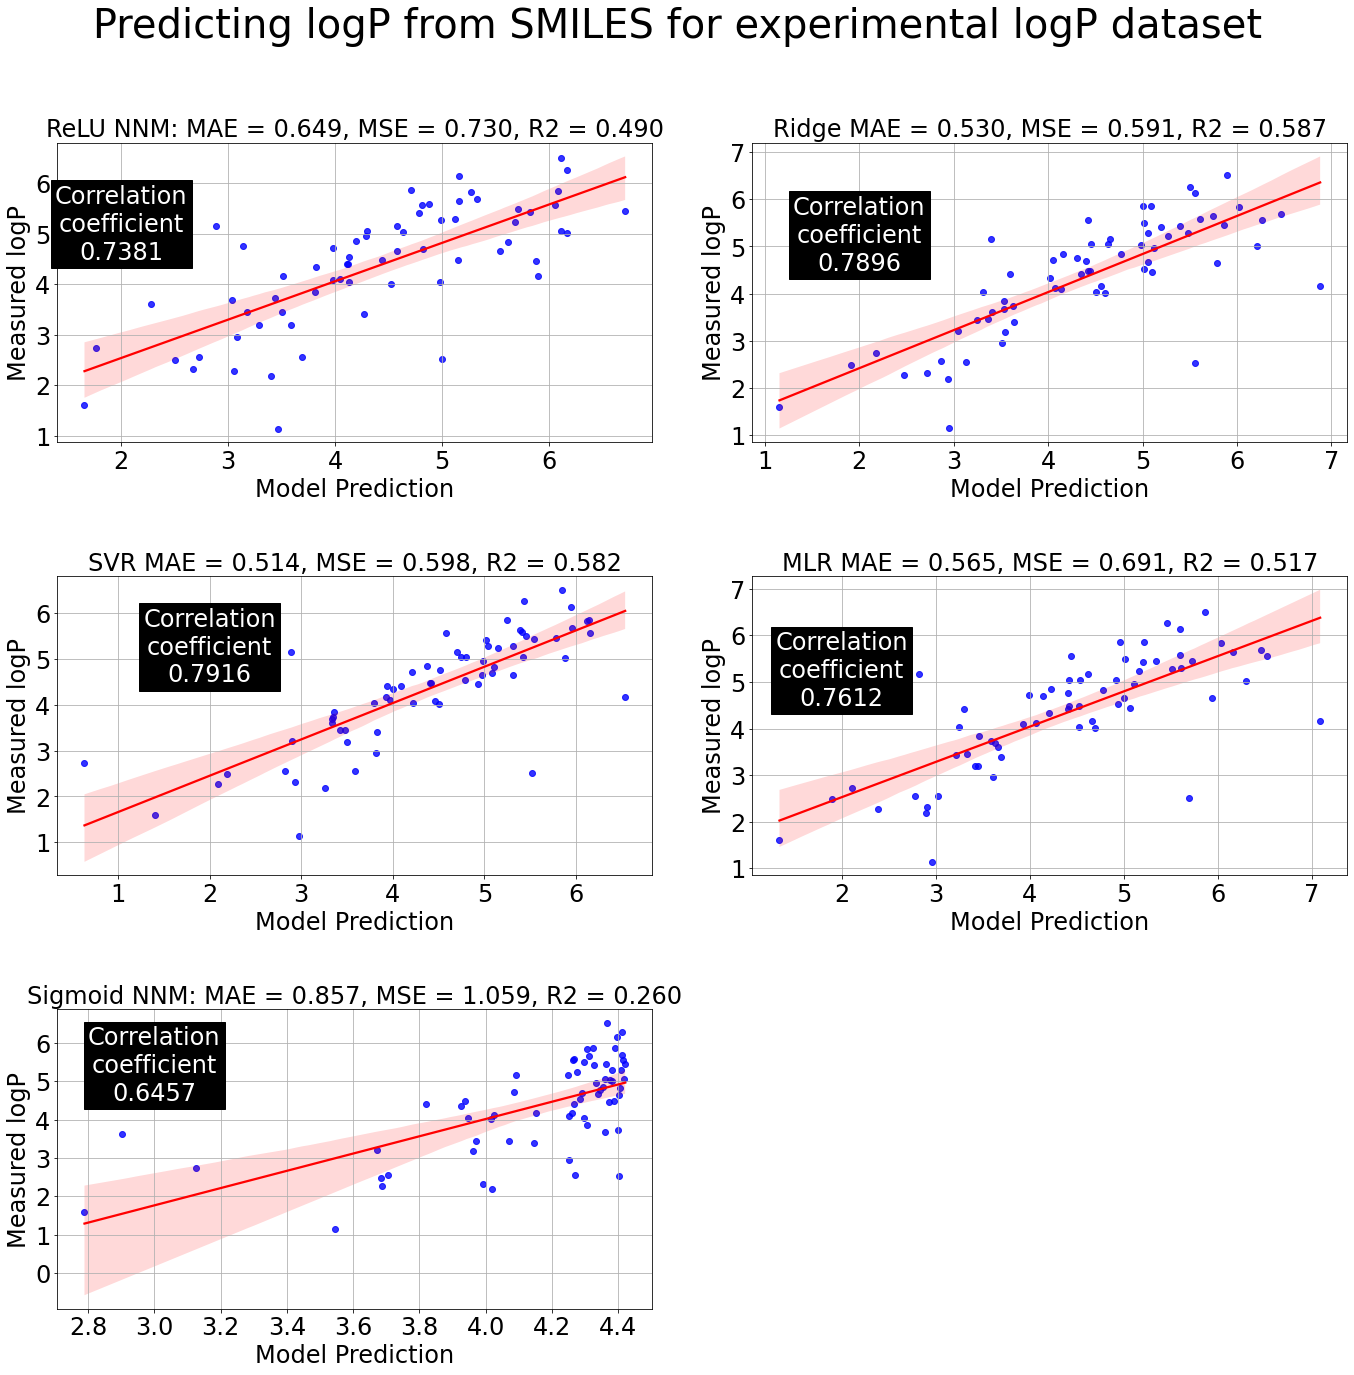

In [59]:
plot_both_evaluation(relu_NNM, ridge_pipe, svr_pipe, mlr_pipe, sigmoid_NNM, X_test1, y_test1)
